# Read Me
This script trains batches of GP's with user-specified structure and digitization options. The training hyperparameters were randomly sampled and a mixture of training strategies (e.g., data augmentation, random digitization etc.) were employed. The best model was selected by testing models on a grid of all possible parameter values.

In [2]:
import sys
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gpytorch
import plotly.express as px
import matplotlib.pyplot as plt
import wandb
import optuna
sys.path.append('..')
sys.path.insert(0, '../src')

# custom imports
from model import GPModel
from grid import Grid
from GPy.models import GPRegression
from acq_funcs import EI, PI, cust_acq, thompson
from train_eval_plotter import prettyplot, vis_pred, vis_acq, plot_gp_res

In [3]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='Ferroelectric Data')
parser.add_argument('--train_flag', type=bool, default=False, metavar='TR',
                    help='train or load pre-saved model (default: True)')
parser.add_argument('--matern_nu', type=float, default=0.5, 
                    help= "matern nu value (vals: 0.5, 1.5,or 2.5)")
parser.add_argument('--epochs', type=int, default=3000, metavar='N',
                    help='number of epochs to train (default: 2500)')
parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                    help='learning rate (default: 0.003)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='number gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=1000, metavar='N',
                    help='how many epochs to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
args = parser.parse_args("")

# Set random seed to reproduce results
torch.manual_seed(args.seed)

## Data Read and Pre-processing

In [4]:
""" Helper functions for file reading and dataset loader """

def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"], color_discrete_sequence=["#72356c"]*23)
    fig.update_layout(template="ggplot2")
    fig.update_layout(width = 800, height=800)
    fig.show()

def datasetmaker(fe_data, scaler):
    """
    [datasetmaker(fe_data, scaler)] filters and transforms the data in pandas df [fe_data] 
    into two tensors, [train_x] for input and [train_y] for output tensors. 
    """
    # filter training data 
    energy_den = fe_data['Energy density new cone (J/cm^2)'].values
    time = fe_data['Time (ms)'].values
    train_x = torch.Tensor(np.array([time, energy_den])).T
    train_y = torch.Tensor(fe_data['2 Qsw/(U+|D|) 1e6cycles'].values)

    # scale inputs
    scaler.fit(train_x)
    train_x = torch.Tensor(scaler.transform(train_x))
    return train_x, train_y

In [5]:
# Load dataset
fe_data = read_dat()
print(fe_data[:10]) # peep data
scaler =  MinMaxScaler()
train_x, train_y = datasetmaker(fe_data, scaler)
num_params, num_samples = train_x.size(dim=1), train_x.size(dim=0)

# Create grid for grid search and evaluation
grid = Grid(train_x)
test_grid, test_arr = grid.test_grid, grid.test_arr

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4         0.5                              2.73                 0.873026
5         0.5                              3.40                 2.677245
6         1.0                              3.79                 1.699015
7         1.0                              6.44                 3.805053
8         1.5                              5.36                 3.334856
9         1.5                              8.99                 4.535153
11        5.0                              8.80                 1.362510
13        5.0                             14.67                 3.841291
19        0.5                              5.24                 1.201357
22        5.0                             14.89                 3.513652


## GP Training and Eval

In [6]:
# Configure parameters for training

class Config():
    def __init__(self):
        self.epochs = args.epochs
        self.kernel = "matern"
        self.lr = args.lr
        self.lscale_1 = 1.0
        self.lscale_2 = 1.0
        self.lscale_3 = None
        self.lscale_4 = None
        self.dim = 2
        self.noise = 0.1

config = Config()

In [7]:
""" Helper functions for creating GP model """

def kernel_func(config_kernel, num_params, lscale):
    """
    [kernel_func(config_kernel, num_params, lscale)] returns kernel function with 
    dimensions specified by [num_params]. 
    """
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))
    elif config_kernel == "matern":
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=num_params, 
        lengthscale = torch.tensor(lscale), lengthscale_constraint = gpytorch.constraints.GreaterThan(5e-2), nu=args.matern_nu))

def make_model(train_x, train_y, num_params, config):
    """
    [make_model(train_x, train_y, num_params, config)] returns likelihood and 
    model with lengthscale, noise, kernel function specified by sweeps. 
    """
    if config.dim == 2:
        lscale = [config.lscale_1, config.lscale_2]
    elif config.dim == 4:
        lscale = [config.lscale_1, config.lscale_2, config.lscale_3, config.lscale_4]
    kernel = kernel_func(config.kernel, num_params, lscale)
    
    print(kernel)
    num_samples = len(train_x)
    noise = config.noise*torch.ones(num_samples)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood, kernel)

    return likelihood, model, lscale

In [8]:
""" Training and evaluation functions """ 

def train(train_x, train_y, num_params, config):
    likelihood, model, lscale = make_model(train_x, train_y, num_params, config)
    model.covar_module.base_kernel.lengthscale = torch.Tensor(lscale)
    training_iter = config.epochs
    # model.covar_module.base_kernel.raw_lengthscale.requires_grad_(False) # disallow training of lengthscale
    
    model.train(), likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss_lst = []

    for i in range(1, training_iter+1):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        if i==1 or i % 500 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 
            loss_lst.append(loss.item())
        optimizer.step()
        
    print(model.covar_module.outputscale.detach().numpy())
    return likelihood, model, loss_lst

def eval_mod(likelihood, model, test_arr):
    """ 
    [eval_mod(likelihood, model, test_arr)] evaluates GP model. 
    """
    model.eval(), likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obs = likelihood(model(test_arr), noise=(torch.ones(len(test_arr))*config.noise))
    return obs

In [11]:
import pickle as pkl 
import os

# set up dir for file search
cur_dir = os.getcwd()
par_dir = os.path.dirname(cur_dir)
model_dir = os.path.join(par_dir, 'models')

In [12]:
if args.train_flag:
    likelihood, model, loss_lst = train(train_x, train_y, num_params, config)
    torch.save({'model_state_dict': model.state_dict(), 'loss': loss_lst}, 
                model_dir + '/model_state.pth')
    # with open(model_dir + "/loss_lst.pkl", 'wb') as file: pkl.dump(loss_lst, file)

In [13]:
likelihood, model, _ = make_model(train_x, train_y, num_params, config)
saved_model = torch.load(model_dir + '/model_state.pth')
model.load_state_dict(saved_model['model_state_dict'])
loss_lst = saved_model['loss']
obs = eval_mod(likelihood, model, test_arr)

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): GreaterThan(5.000E-02)
  )
  (raw_outputscale_constraint): Positive()
)


### Visualize Training Results

     Metric  Value
0      RMSE  0.106
1       MAE  0.088
2  Spearman  0.983
3  R² score  0.993


 /Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?


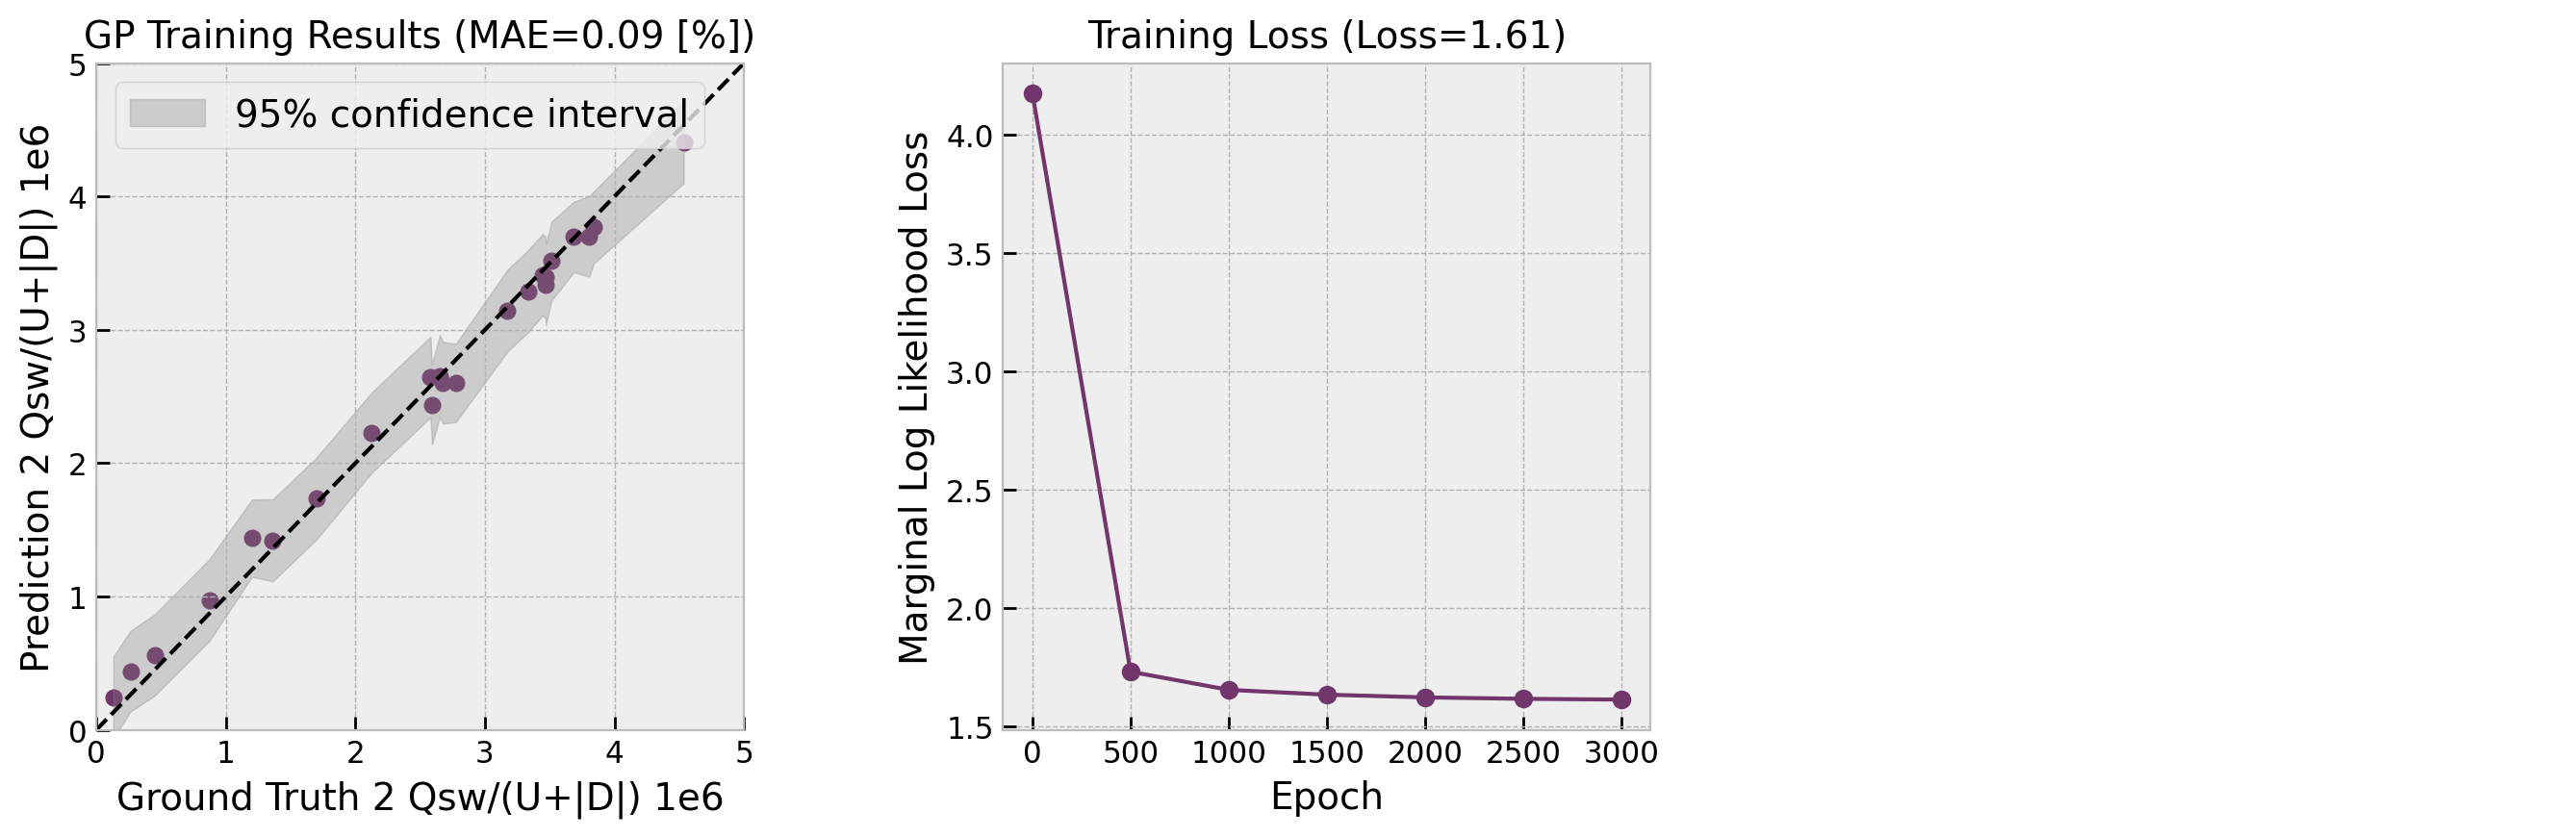

In [14]:
round_three = lambda val: np.round(val, 3) 
model.eval(), likelihood.eval()
f_obj = model(train_x)
y_preds, f_var = likelihood(f_obj), f_obj.variance

with torch.no_grad(): y_preds_mean, f_var = y_preds.mean.numpy(), np.sqrt(f_var).numpy()
plot_gp_res(train_y, y_preds_mean, loss_lst, f_var)

In [15]:
# acquisition function for prediction/exploration
def get_bounds(n): return [n for i in range(config.dim)]

def unravel_acq(acq_func, obs, bounds, train_y, nshape):
    """ 
    [unravel_acq(acq_func, obs, bounds, train_y, nshape)] is a helper function 
    for acq that returns the coordinates of the maximum value of the acq_func 
    over the test grid in the form of a tuple (row_index, column_index). 

    row_index = index into time
    column_index = index into energy density
    """
    acq = acq_func(obs, bounds, train_y).detach().numpy().reshape(nshape).T
    return np.unravel_index(acq.argmax(), acq.shape)

def acq(obs, train_y, bounds):
    """ 
    [acq(obs, train_y, bounds)] evaluates acquisition functions on current 
    predictions (observations) and outputs suggested points for exploration 
    on manifold. 
    """
    nshape = tuple(bounds)
    transpose = lambda tensor: tensor.detach().numpy().reshape(nshape).T
    unravel_acq_gen = lambda acq_func: unravel_acq(acq_func, obs, bounds, train_y, nshape)
    acq_coords = [unravel_acq_gen(acq) for acq in [PI, EI, cust_acq, thompson]]

    lower, upper = obs.confidence_region()
    upper_surf, lower_surf = transpose(upper), transpose(lower)
    ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)
    acq_coords.append(ucb)

    pred_labels = obs.mean.view(nshape).T
    pred_var = transpose(obs.variance)
    max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)
    acq_coords.append(max_var)

    # acqs gives pairs corresponding to indices of time and energy density 
    # recommendations in grid; the pairs index into array pred_labels 
    acq_keys = ["PI", "EI", "CA", "TH", "UCB", "Max Var"]
    acqs = {k:v for k,v in zip(acq_keys, acq_coords)}

    return pred_labels, upper_surf, lower_surf, acqs

In [16]:
# export predictions to csv
def pred_to_csv(acqs, raw_pred_labels, raw_test_grid, file_out = "preds.csv"):
    """
    [pred_to_csv(acqs, raw_pred_labels, raw_test_grid)] outputs suggested
    inputs and their respective predicted outputs to csv; returns suggested point
    corresponding to ucb acquisition.
    """   
    dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
    file = open(dir + file_out, "w", encoding="utf-8")
    acq_data = {'Acq':[], 'Time (ms)':[], 'Energy density new cone (J/cm^2)':[], '2 Qsw/(U+|D|) 1e6':[]}

    for lab, coords in acqs.items(): 
        time_val = raw_test_grid[coords[1]].tolist()[0]
        energy_den_val = raw_test_grid[coords[0]].tolist()[1]
        fig_of_merit = raw_pred_labels[coords].item()
        acq_data["Acq"].append(lab)
        acq_data['Time (ms)'].append(time_val)
        acq_data['Energy density new cone (J/cm^2)'].append(energy_den_val)
        acq_data['2 Qsw/(U+|D|) 1e6'].append(fig_of_merit)        

    df = pd.DataFrame(acq_data)
    df.to_csv(file, index=False)
    return df

### Save Predictions and Visualize 

In [ ]:
# get normalized suggestions
bounds = get_bounds(n=30)
pred_labels, upper_surf, lower_surf, acqs = acq(obs, train_y, bounds)

# undo scaling
raw_train_x, raw_test_grid = scaler.inverse_transform(train_x), scaler.inverse_transform(test_grid)

# save to csv, get suggested points
acq_df = pred_to_csv(acqs, pred_labels, raw_test_grid)

In [ ]:
import plotly.graph_objects as go
def vis_acq(train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf, acqs):
    fig = go.Figure(data=[go.Surface(z=pred_labels.numpy(), 
                                    x=test_grid[:,0],
                                    y=test_grid[:,1],
                                    opacity = 0.8,
                                    colorscale = "Burg",
                                    colorbar=dict(thickness=15, len=0.5),
                                    name='GP regression')])

    fig.add_trace(go.Surface(z=upper_surf, x=test_grid[:,0],
                    y=test_grid[:,1], opacity=0.2, colorscale = "Burg", showscale=False))

    fig.add_trace(go.Surface(z=lower_surf, x=test_grid[:,0],
                            y=test_grid[:,1], 
                            colorscale = "Burg",
                            opacity=0.2, showscale=False))
    fig.add_trace(go.Scatter3d(x=train_x[:,0], 
                                y=train_x[:,1], 
                                z=train_y.numpy(), 
                                mode='markers', 
                                name='training data', 
                                marker={'color':'#72356c'}))
    
    for acq_name, acq_val in acqs.items():
        fig.add_trace(go.Scatter3d(x=[test_grid[acq_val[1], 0]], 
                                y=[test_grid[acq_val[0], 1]],
                                z=[pred_labels[acq_val[0], acq_val[1]]], mode='markers', 
                                name= acq_name)) 

    fig.update_layout(width=1200, height=750,
                    margin=dict(r=20, l=10, b=15, t=10),
                    legend=dict(orientation="h", yanchor="bottom", 
                                y=0.9, xanchor="right",x=0.75),
                    scene=dict(
                        xaxis_title="Pulse Width (msec)",
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='2 Qsw/(U+|D|) 1e6')
                    )

    fig.update_layout(template="ggplot2")
    camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0),
                    eye=dict(x=2, y=0.9, z=0.7))

    fig.update_layout(scene_camera=camera)

    fig.show()

In [ ]:
vis_acq(raw_train_x, train_y, raw_test_grid, pred_labels, upper_surf, lower_surf, acqs)

In [ ]:
# check fig of merit of NLCB prediction point

model.eval(), likelihood.eval()
df_nlcb = pd.read_csv(par_dir + "/predictions/emu_preds")

nlcb_scaled = scaler.transform(df_nlcb.iloc[0, 1:3].values.reshape(1,2))
print(nlcb_scaled)
y_preds_nlcb = likelihood(model(torch.Tensor(nlcb_scaled)))

with torch.no_grad(): y_preds_nlcb_mean = y_preds_nlcb.mean.numpy()
print(y_preds_nlcb_mean)

[[0.08888889 0.24862314]]
[2.938652]


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.



In [ ]:
# check fig of merit of old UCB suggested point

model.eval(), likelihood.eval()
# df_nlcb = pd.read_csv(par_dir + "/predictions/emu_preds")

old_ucb_scaled = scaler.transform(np.array([1.17, 8.85]).reshape(1,2))
print(old_ucb_scaled)
y_preds_old_ucb = likelihood(model(torch.Tensor(old_ucb_scaled)))

with torch.no_grad(): y_preds_old_ucb_mean = y_preds_old_ucb.mean.numpy()
print(y_preds_old_ucb_mean)

old_pi_scaled = scaler.transform(np.array([1.33, 8.85]).reshape(1,2))
print(old_pi_scaled)
y_preds_old_pi = likelihood(model(torch.Tensor(old_pi_scaled)))

with torch.no_grad(): y_old_pi_scaled_mean = y_preds_old_pi.mean.numpy()
print(y_old_pi_scaled_mean)

[[0.14888889 0.48151064]]
[3.0784984]
[[0.18444444 0.48151064]]
[3.477439]


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.

/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.

